# outline of this notebook:


In this notebook the model is trained only with the samples which contains traffic lights.


1. we can visualize the a2d2 dataset and the redifined labels of the traffic signals.

2. Train the model or load the fine tuned model perform the inference with two approches (i.e, standard inference and Mc-dropout based) on the clean data and augmented data.

3. The model performace is evaluated with Intersection of Union and Shanon's entropy to estimate uncertainity:
       $$\mathcal{H} \mathbf{(p) = -{\sum_{i=1}^{n}\mathbf{p_ilog(p_i)}}}$$

In [1]:
# can clone the git repo for the model 
# !git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git

In [1]:
import sys, os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy 
sys.path.append('data_utils')
from data_utils.dataloader import A2d2dataset
from data_utils.utils import train_val_test
from train import train_step
from test import test_predictions, mcd_pred
from metrics import iou_metric, entropy
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np  

sys.path.append('DeepLabV3Plus-Pytorch')
import network

#### Data preprocessing  

Dataset with all the labels one step before redefining the labels 

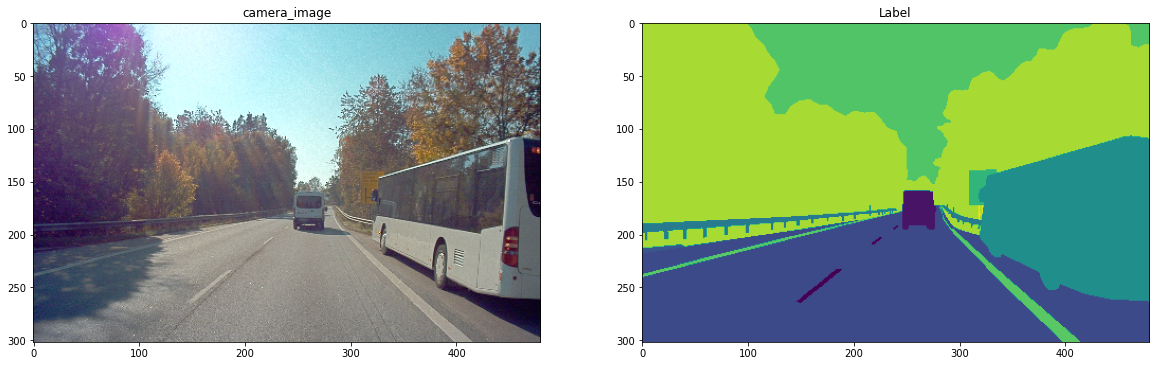

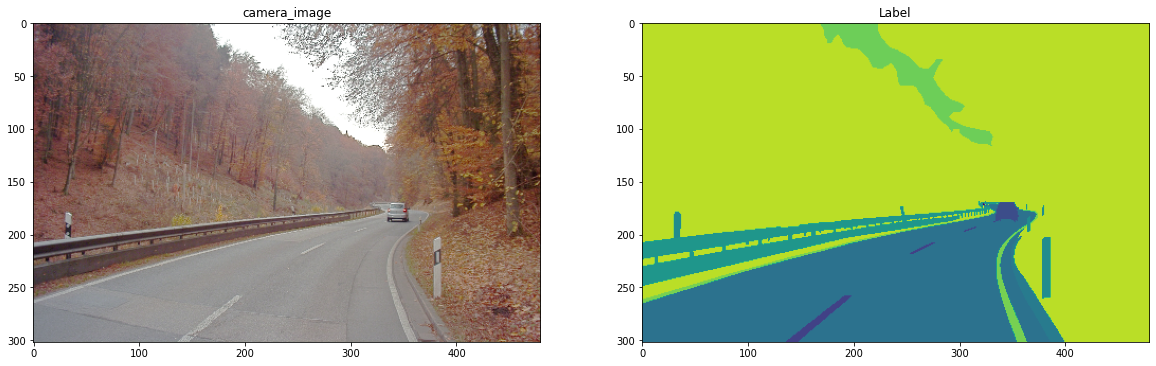

In [2]:
path_to_data = 'a2d2_compressed'
transform = transforms.Compose([transforms.ToTensor()])
complete_dataset = A2d2dataset(root = 'a2d2_compressed', image_folder= 'images', labels_folder= 'labels',transforms= transform)
dataloader = DataLoader(complete_dataset, batch_size = 16, shuffle= True)

images, labels = next(iter(dataloader))
for i in range(2):
    fig, ax = plt.subplots(1, 2, figsize = (20, 20))
    ax[0].imshow(images[i].squeeze(0).numpy().transpose(1,2,0))
    ax[0].set_title('camera_image')
    ax[1].imshow(labels[i].numpy().transpose(1,2,0))          
    ax[1].set_title('Label')
    plt.savefig('dataset_samples.png')

Dataset after masking and filtering only traffic signals I created a folder which has newly defined labels which contains only traffic signs.

--------------------- Total number of samples with only traffic light : 1307 samples -------------------------


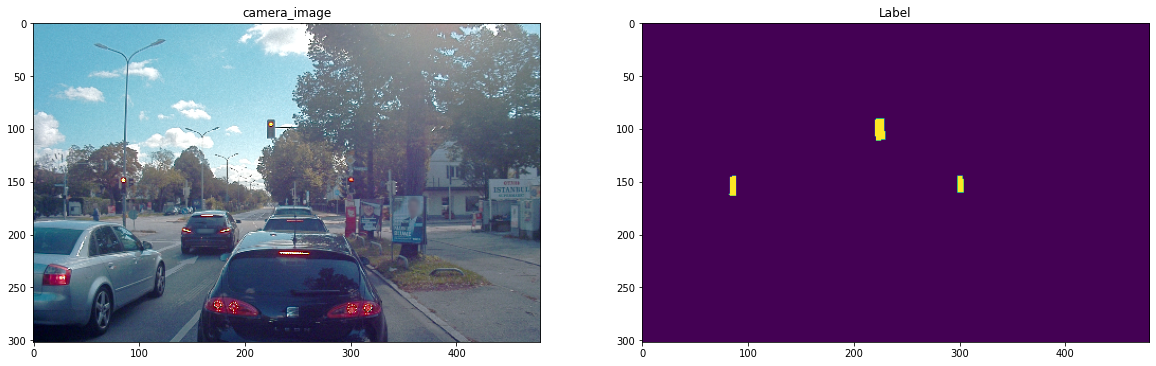

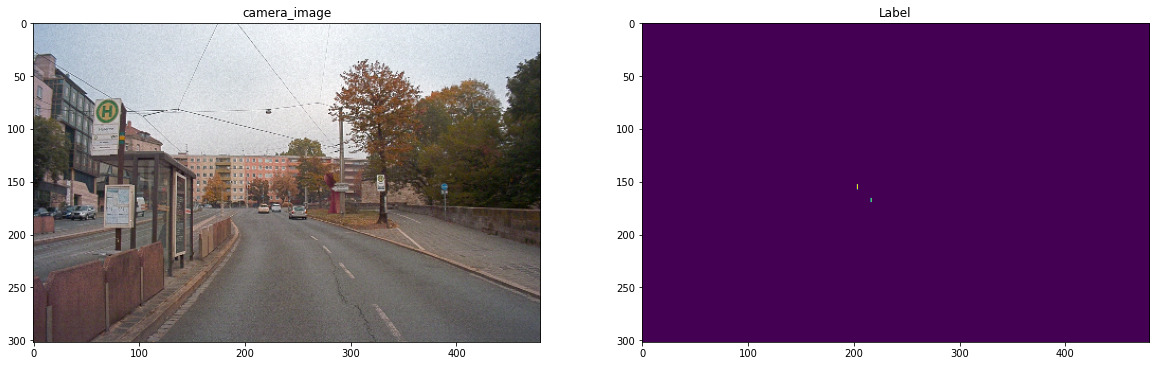

In [11]:
a2d2_dataset = A2d2dataset(root = 'a2d2_compressed', image_folder= 'images_traffic', labels_folder= 'binary_labels_traffic',transforms= transform)
print('--------------------- Total number of samples with only traffic light : ' + str(len(a2d2_dataset)) + ' samples -------------------------' )
split_dataset = train_val_test(dataset= a2d2_dataset)

train_dataloader = DataLoader(split_dataset['train'], batch_size = 16, shuffle= True)
valid_dataloader = DataLoader(split_dataset['val'], batch_size = 16, shuffle= False)
test_dataloader = DataLoader(split_dataset['test'], batch_size = 16, shuffle= False)

images, labels = next(iter(train_dataloader))
for i in range(2):
    fig, ax = plt.subplots(1, 2, figsize = (20, 20))
    ax[0].imshow(images[i].squeeze(0).numpy().transpose(1,2,0))
    ax[0].set_title('camera_image')
    ax[1].imshow(labels[i].numpy().transpose(1,2,0))
    ax[1].set_title('Label')


#### Model Definition

Load the adopted Deepv3plus model and the weights for my training I have taken mobilenet based model computationally faster.


modification to the model:
    1. Added a dropout layer and modified the last layer depending on the number of classes.
    2. training only the classfication part of the model.


In [4]:
model = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=16)   ###Adopted from the Deeplabveplus ####
model.load_state_dict(torch.load('trained_model/best_deeplabv3plus_mobilenet_cityscapes_os16.pth')["model_state"]) 

# freeze the backbone model parameters
for params in model.backbone.parameters():
    params.requires_grad = False

# Added a dropout layer in the classifier model to perform uncertainty estimation during inference time (MC-dropout)
model.classifier.project = model.classifier.project.append(nn.Dropout(p = 0.3,inplace= False))

#modeified the last layer depending on our number of classes
model.classifier.classifier[-1] =  torch.nn.Conv2d(in_channels= 256, out_channels= 1, kernel_size= (1, 1), stride= (1,1))

##### Model training 

The model is trained for 25 epochs with the learning rate of 1e-3
using the Binary cross entropy  as a loss function with Adam optimizer

In [5]:
total_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
learning_rate = 1e-3
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

##### training step

-----training done, valdiating-----
epoch: 0/25, traning_loss :0.158106, validation_loss :0.037059
-----training done, valdiating-----
epoch: 1/25, traning_loss :0.021440, validation_loss :0.014895
-----training done, valdiating-----
epoch: 2/25, traning_loss :0.011596, validation_loss :0.009589
-----training done, valdiating-----
epoch: 3/25, traning_loss :0.008152, validation_loss :0.007699
-----training done, valdiating-----
epoch: 4/25, traning_loss :0.006452, validation_loss :0.006264
-----training done, valdiating-----
epoch: 5/25, traning_loss :0.005247, validation_loss :0.005248
-----training done, valdiating-----
epoch: 6/25, traning_loss :0.004456, validation_loss :0.004982
-----training done, valdiating-----
epoch: 7/25, traning_loss :0.003951, validation_loss :0.004251
-----training done, valdiating-----
epoch: 8/25, traning_loss :0.003522, validation_loss :0.003834
-----training done, valdiating-----
epoch: 9/25, traning_loss :0.003282, validation_loss :0.003687
-----train

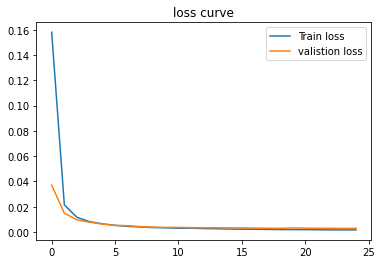

In [7]:
training_loss, validation_loss = train_step(model, train_dataloader, valid_dataloader, total_epochs, loss_function, optimizer, device)
plt.plot(range(total_epochs), training_loss, label = 'Train loss')
plt.plot(range(total_epochs), validation_loss, label = 'validtion loss')
plt.title('loss curve')
plt.legend()
plt.savefig('training_losscurve.png', dpi = 200)

##### Load the trained and saved model parameters

In [6]:
model.load_state_dict(torch.load('trained_model/new_model_weights_dropout_04.pth'))

<All keys matched successfully>

### Inference on the test dataset:

Perform two diffrence inference tecnique:
1. standard inference (considered as a baseline)
2. Monte-Carlo dropout : perform multiple forward passes by enabling dropout during inference time (would be a stochastic process), and the final prediction is the average of all the predictions. 
     
In the Plot we can see the image, label, model prediction and the uncertainty map

In [10]:
overall_iou = 0.0
with torch.no_grad(): 
    for idx, (images, labels) in enumerate(test_dataloader):
        images = images.float().to(device)
        labels = labels.float().to(device)
        predicted = model(images)
        predicted =torch.sigmoid(predicted).cpu().numpy()
        iou = iou_metric(predicted, labels.cpu().numpy())
    overall_iou += iou.item()
print('overall_iou on test data', overall_iou)

overall_iou on test data 0.6073232443018568


iou 2.735093591548744e-07
time taken: 0.7200732231140137
iou 2.735093591548744e-07
time taken: 0.2092118263244629
iou 0.7849624107025335
time taken: 0.772130012512207
iou 0.6949924194558271
time taken: 0.20537090301513672
iou 2.4159941629581027e-06
time taken: 0.8865358829498291
iou 2.4159941629581027e-06
time taken: 0.20980191230773926
iou 0.6757575900006607
time taken: 0.7146346569061279
iou 0.5292307902285247
time taken: 0.20527362823486328
iou 2.415999416294543e-07
time taken: 0.7097334861755371
iou 2.415999416294543e-07
time taken: 0.20446419715881348


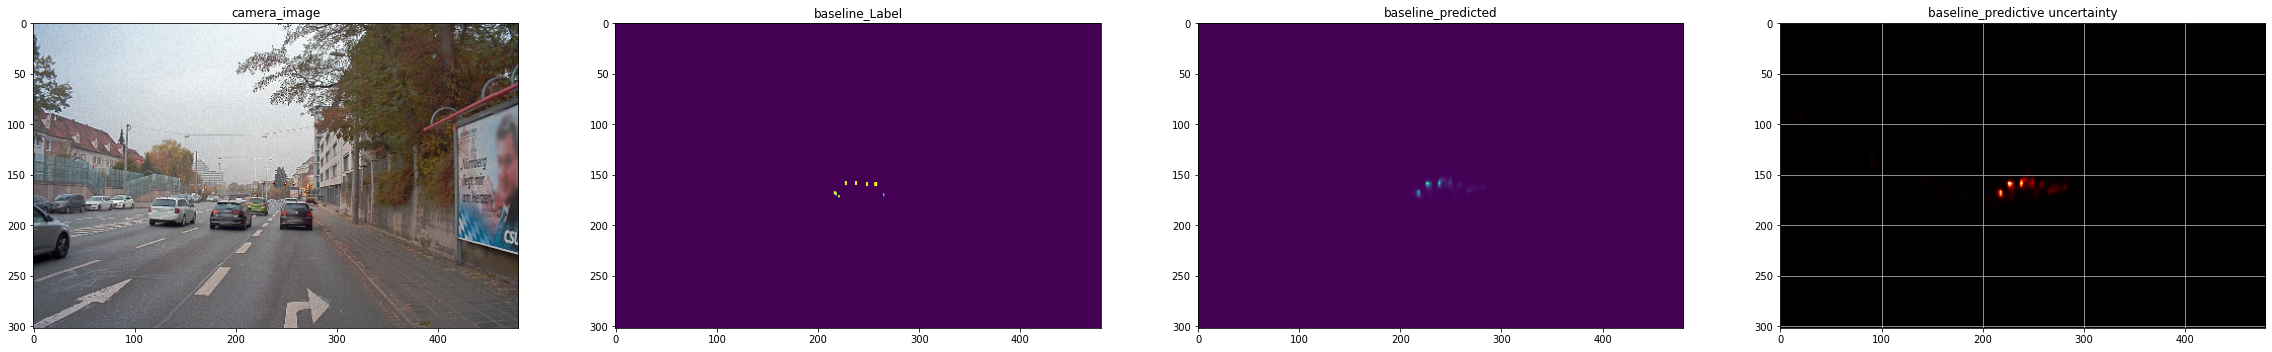

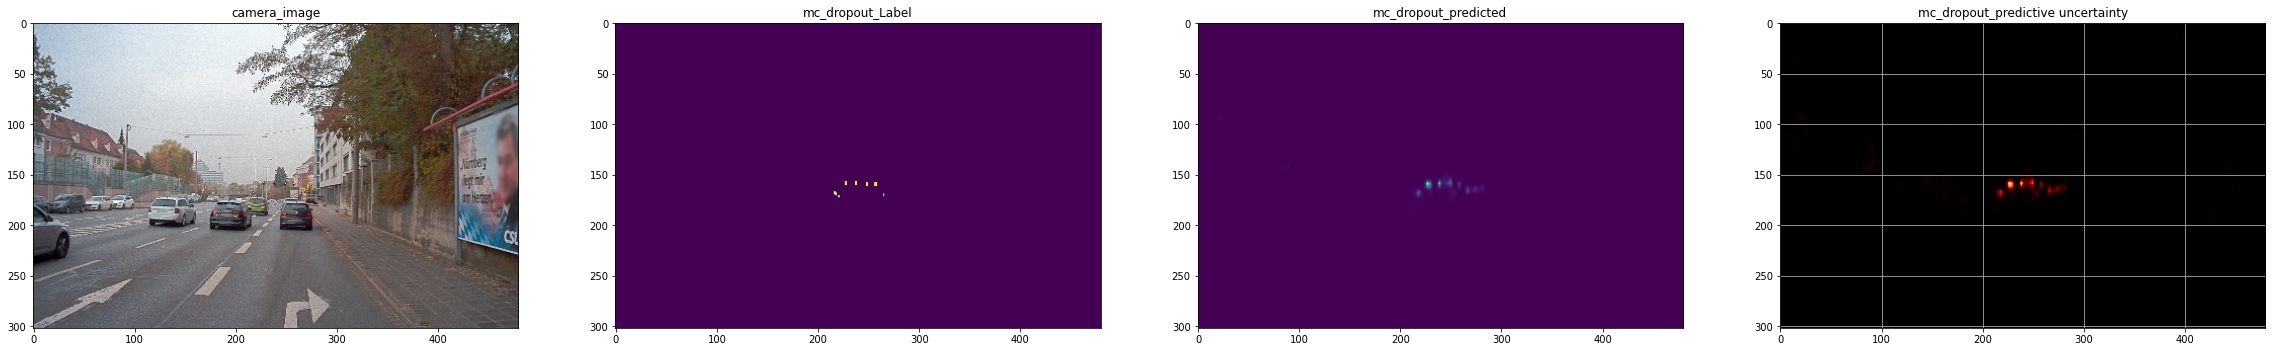

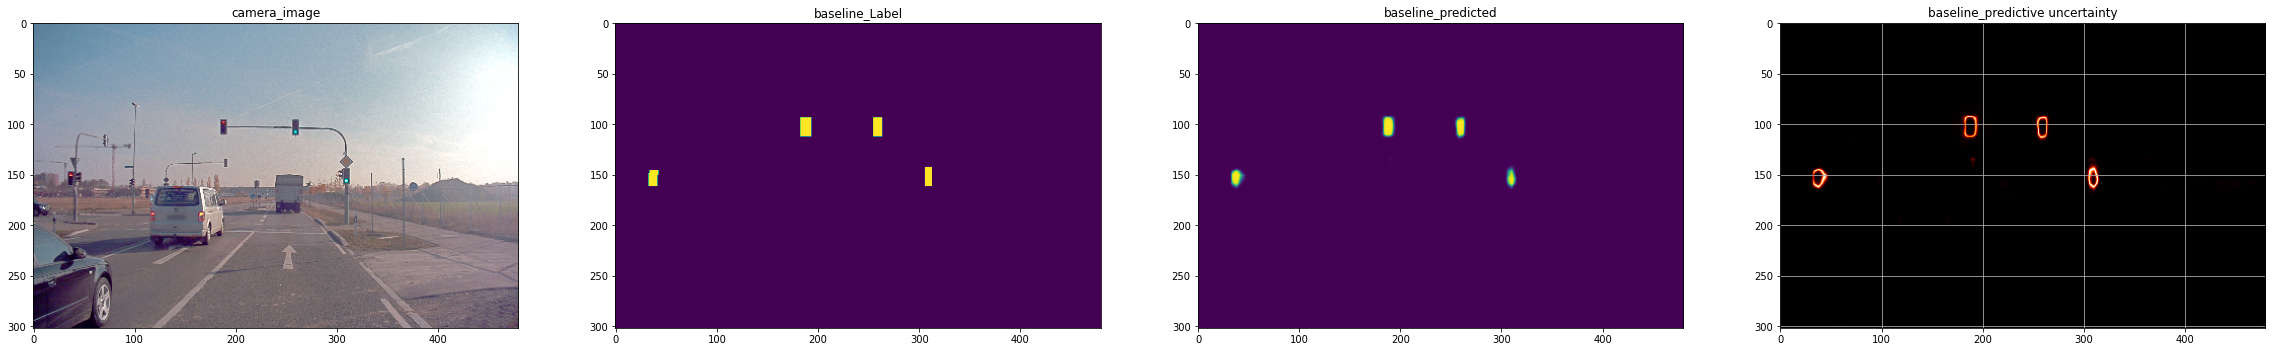

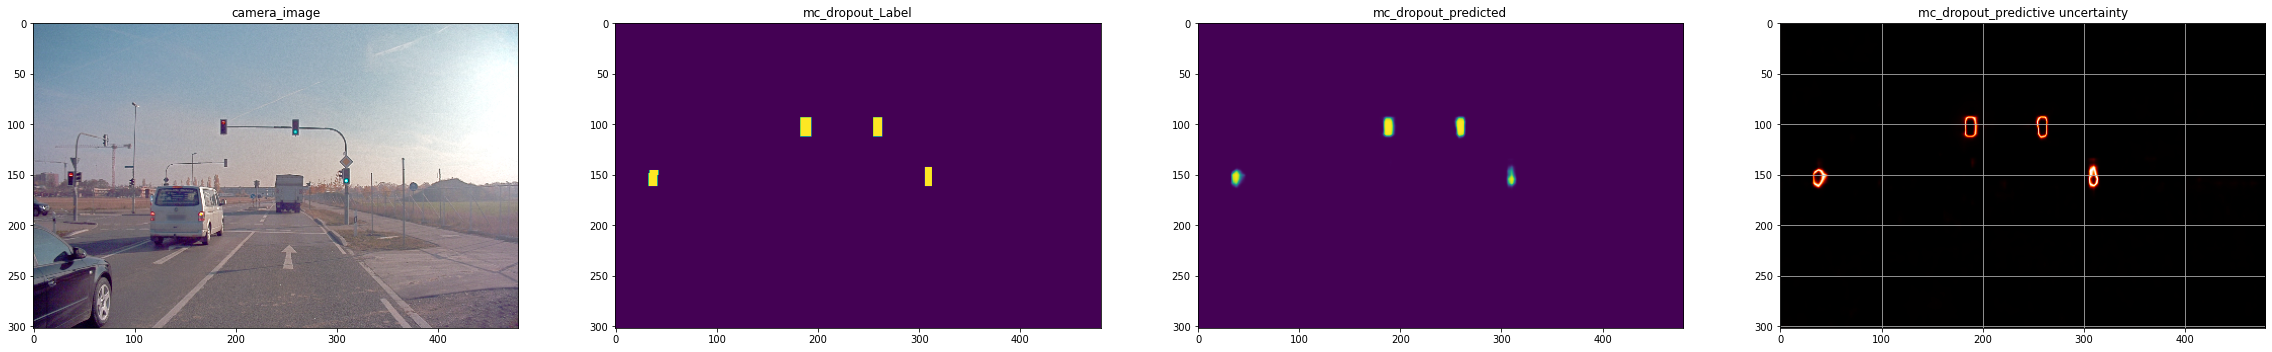

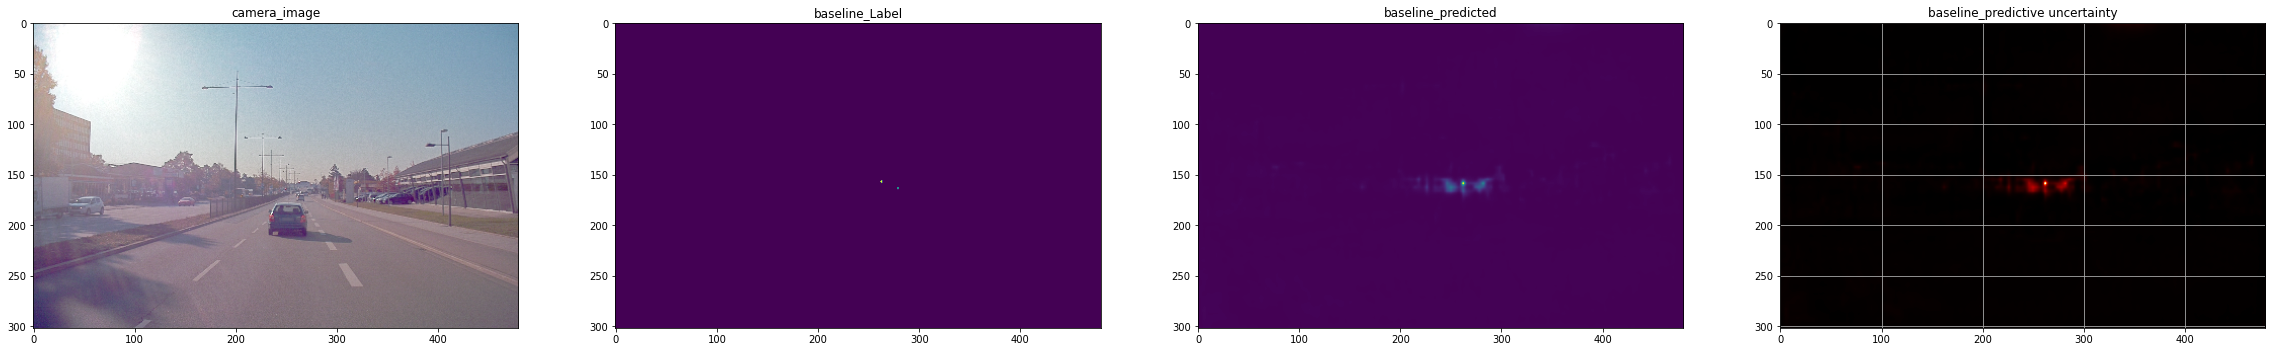

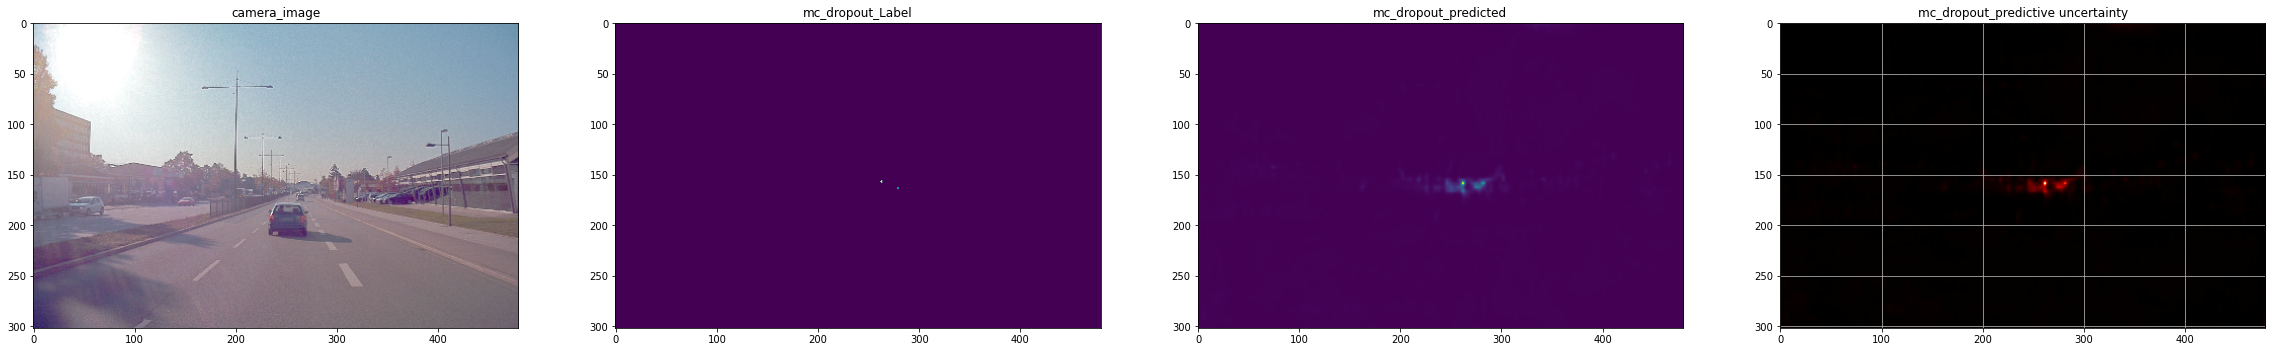

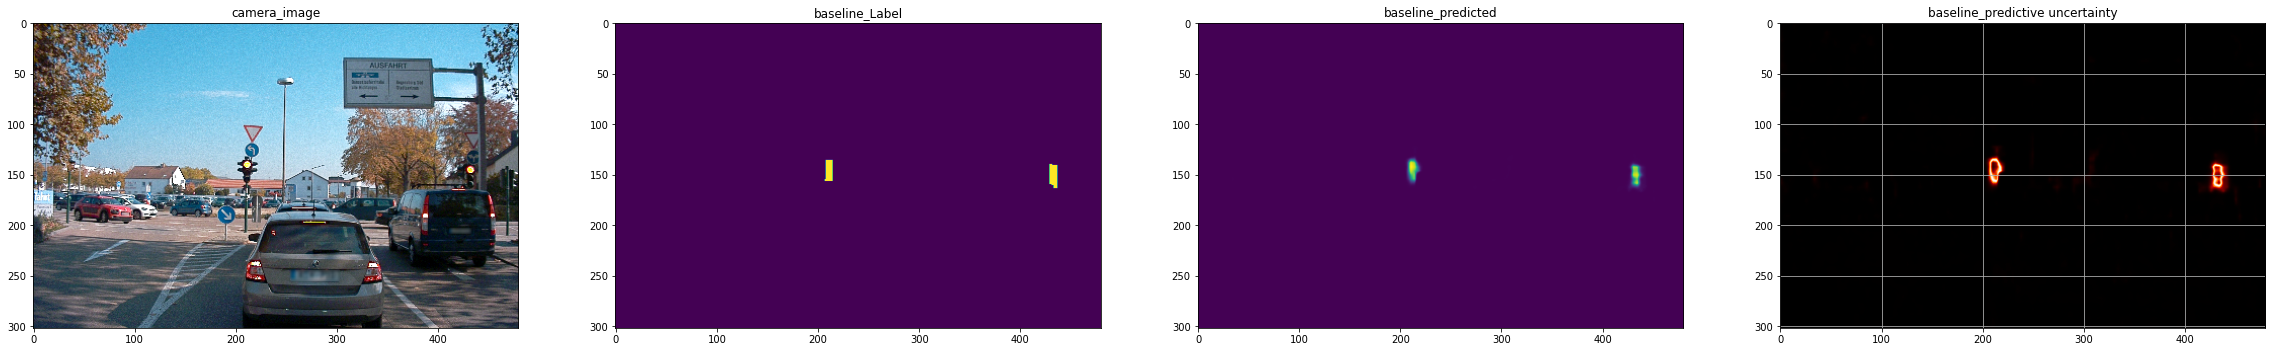

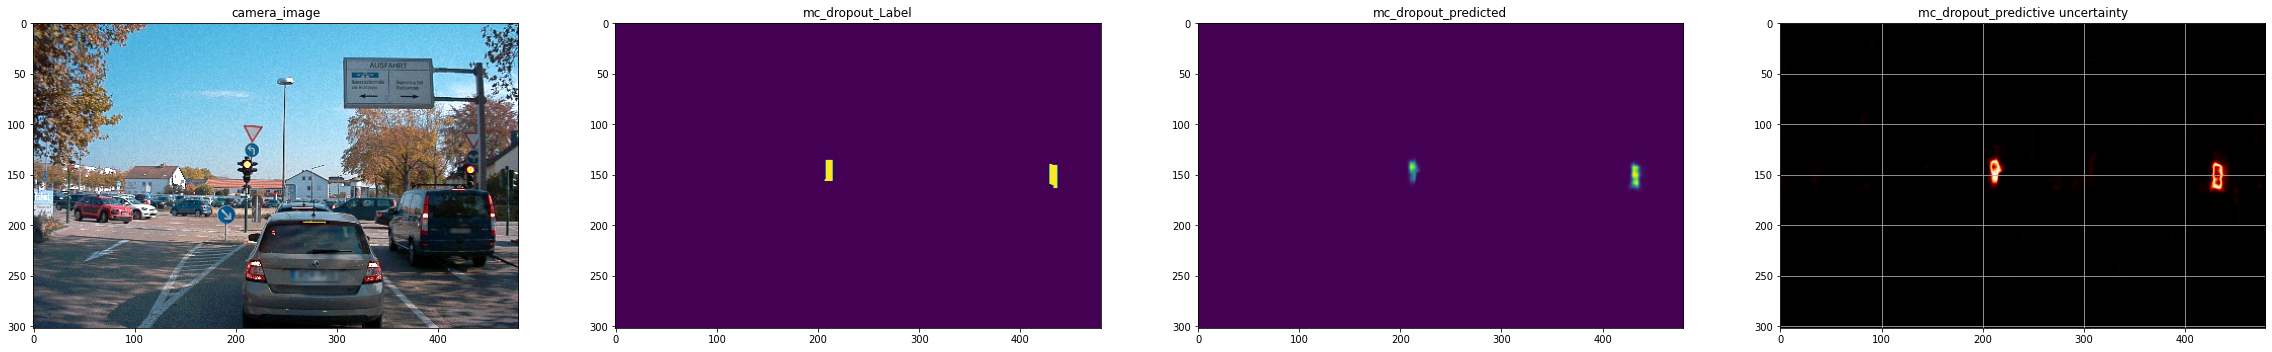

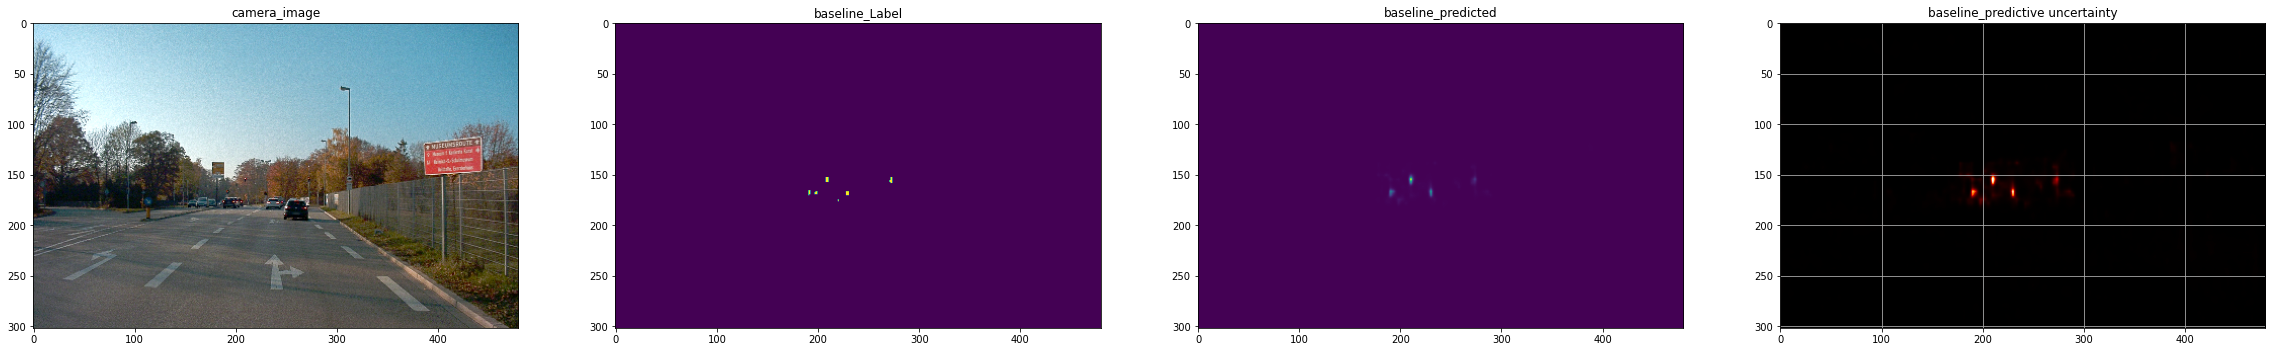

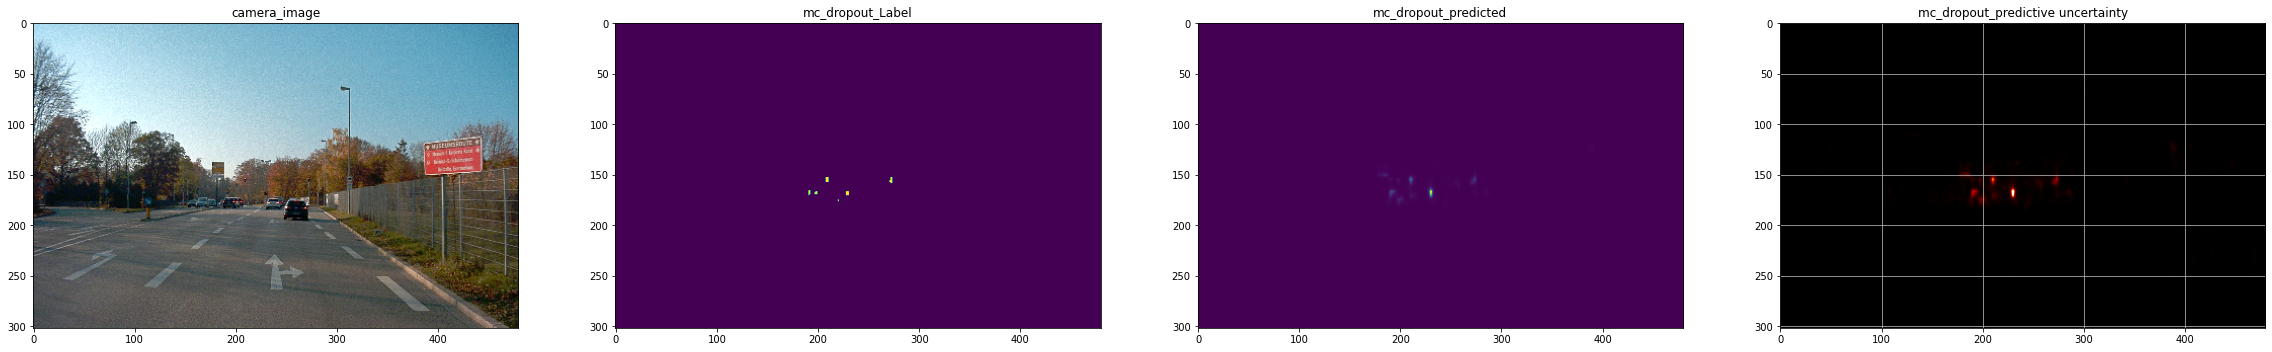

In [52]:
test_images, test_labels = next(iter(test_dataloader))
for i in range(5):
    predicted, entropy_ = test_predictions(model, test_images[i], test_labels[i], device)
    average_pred, entropy_ = mcd_pred(model, test_images[i], test_labels[i], device, forward_passes= 5)  


#### Augment the test data and perform inference

iou 0.15543073453722114
time taken: 0.8265068531036377
iou 0.18629552846993574
time taken: 0.3289604187011719
iou 0.5519031198058926
time taken: 0.719444990158081
iou 0.5064377743816975
time taken: 0.29468417167663574


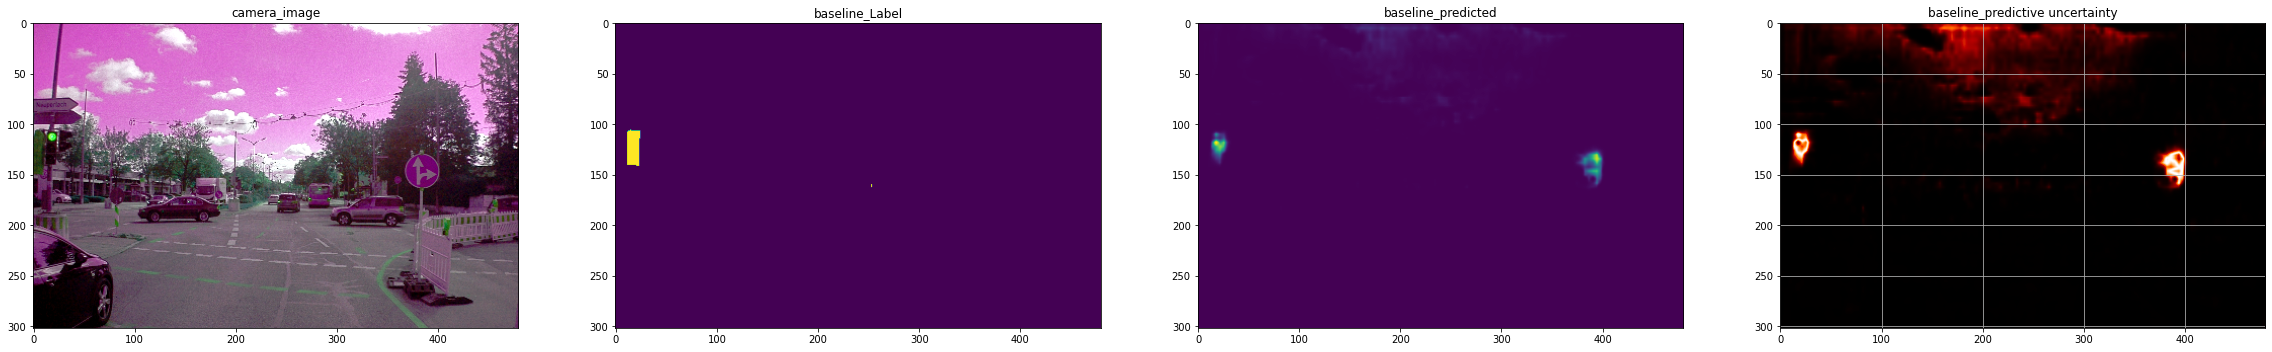

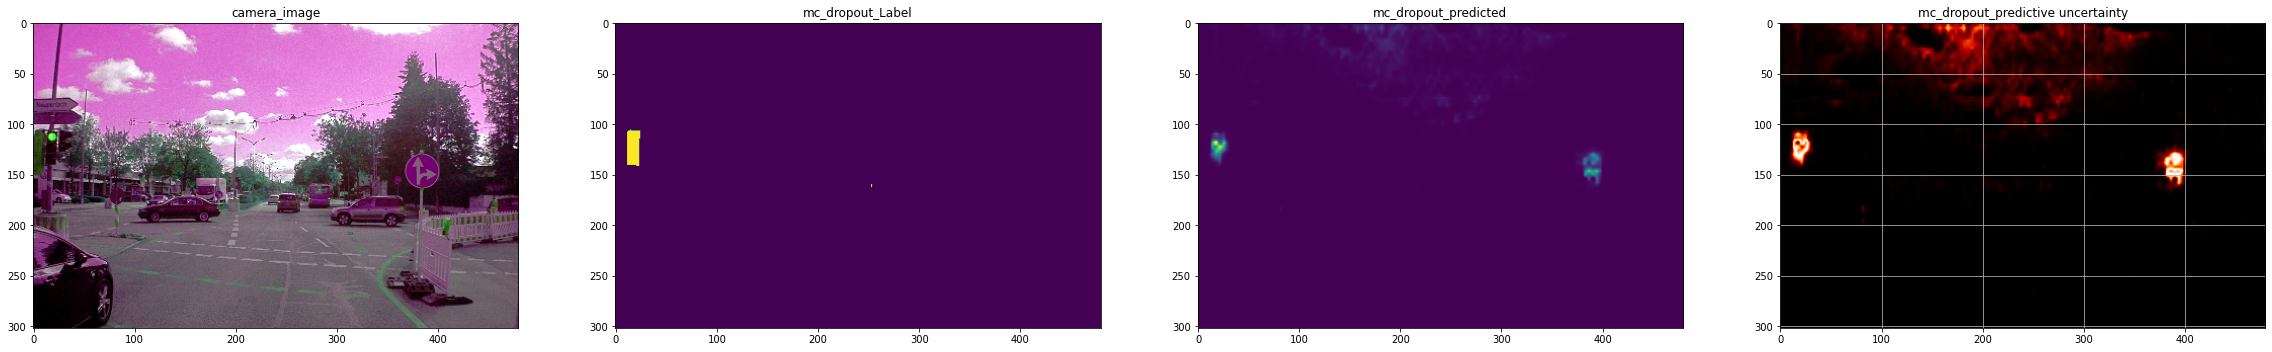

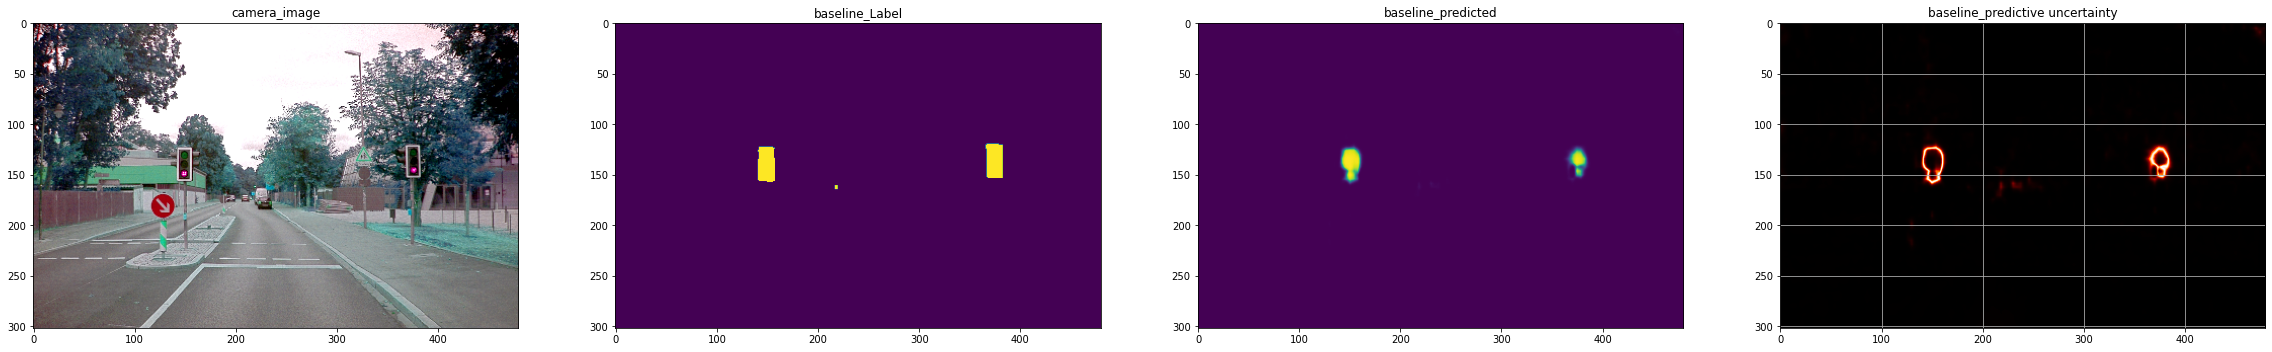

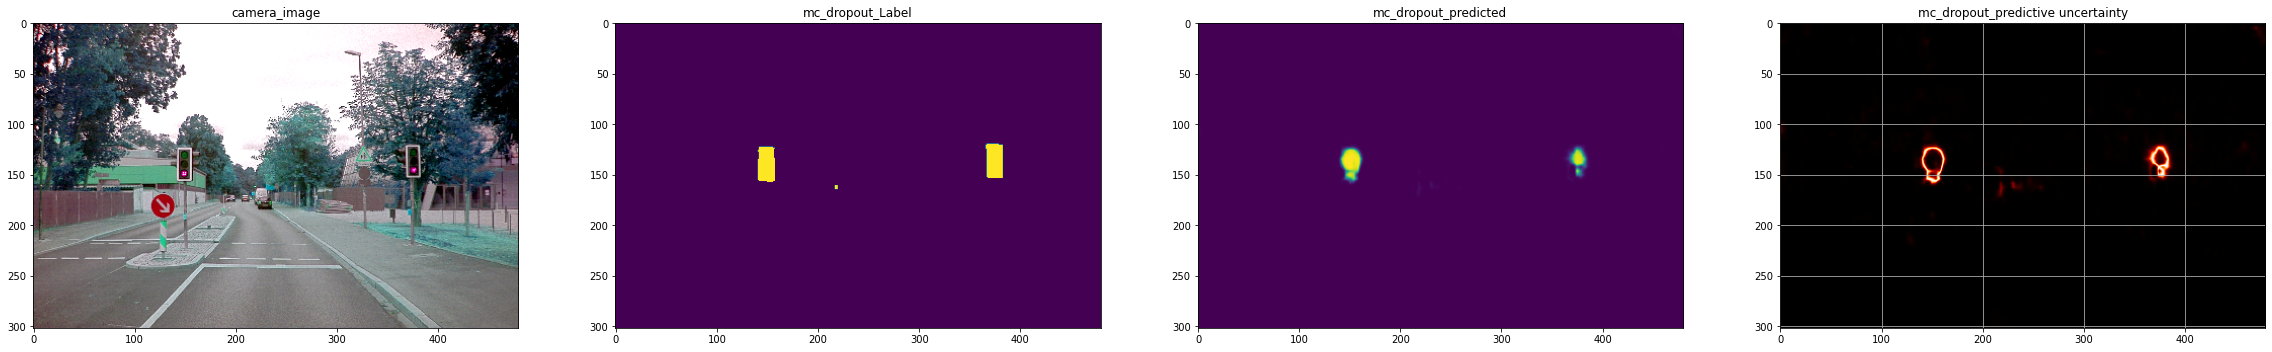

In [44]:

jitter = transforms.Compose([transforms.ToPILImage(), transforms.ColorJitter(hue = 0.5, contrast= 0.8), transforms.ToTensor()])

for i in range(2):
    augment_img = jitter(test_images[i])
    predicted, entropy_ = test_predictions(model, augment_img, test_labels[i], device)
    average_pred, entropy_ = mcd_pred(model, augment_img, test_labels[i], device, 10)